In [174]:
#Make a timeseries that is easy to take slices out. So you can investigate little sections in more detail.
#Try making a dict

import pandas as pd
import numpy as np
from datetime import datetime

column_names=["year","month","day","hour","ws"]
dtype={"year":int,"month":int,"day":int,"hour":int,"ws":float}

datafile='/home/sophie/projects/windspeed/data/61401BirMoghrein_allwinds.txt'

#specify the columns you want to group together. Can't include hour at this point as it is not in the right format. 
date_spec = {'date_time': [0,1,2]}

#when you use keep_dat_col it keeps them as objects, not as the dtype you read them in as.
wind = pd.read_csv(datafile, sep=" ", names=column_names, parse_dates=date_spec, keep_date_col=True, index_col=False ) 

#Dealing with hour - going from 600, 1200 etc to 6,12, 18
wind["hour"]=(wind["hour"]/100).astype(int)

#combining year, month, day that were parsed together into date_time with hour, which is now in the correct format.
wind['date_time'] = pd.to_datetime(wind.date_time) + wind.hour.astype('timedelta64[h]')

In [175]:
print wind.head()

#are there really no 0 values? Yes, I checked the script
zero_sub = wind[wind['ws'] == 0]
print zero_sub.count()

#split up the dataframe to practise overplotting
wind_00=wind[wind['hour'].isin([0])]
wind_06=wind[wind['hour'].isin([6])]
wind_12=wind[wind['hour'].isin([12])]
wind_18=wind[wind['hour'].isin([18])]

print wind_00['ws'].count()
print wind_06['ws'].count()
print wind_12['ws'].count()
print wind_18['ws'].count()

            date_time  year month day  hour       ws
0 1984-03-01 06:00:00  1984     3   1     6  3.54349
1 1984-03-01 12:00:00  1984     3   1    12  1.86284
2 1984-03-01 18:00:00  1984     3   1    18  1.01765
3 1984-03-02 06:00:00  1984     3   2     6  2.29602
4 1984-03-02 12:00:00  1984     3   2    12  4.95783
date_time    0
year         0
month        0
day          0
hour         0
ws           0
dtype: int64
1
6630
6860
6314


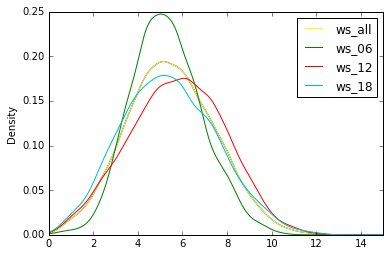

In [176]:
#make a new column (or a new dataframe) which takes the average of each month. 
#I think the best way to do this would be to make a histogram and perform actions on the histogram

#import some plotting procedures
%matplotlib inline

import matplotlib.pyplot as plt

#first try a density plot
#df.plot() is the same as plt.plot()
wind['ws'].plot(kind='kde')
#wind['ws'].plot.kde() #also works

#Interestingly, don't need to specify it is an "overplot"

#This is one way to do it.
wind['ws'].plot(kind='kde',xlim=(0,15),label='ws_all',legend=True, c='yellow')
wind_06['ws'].plot(kind='kde',legend=True, label='ws_06')
wind_12['ws'].plot(kind='kde',legend=True, label = 'ws_12')
wind_18['ws'].plot(kind='kde',legend=True, label = 'ws_18')

plt.show()


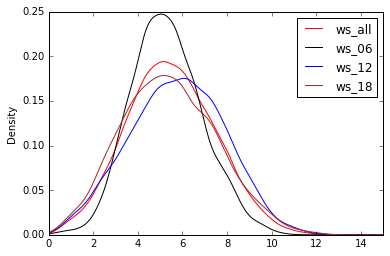

In [177]:
#This might be the most efficient way to do things which avoids writing similar things out and will be more adaptable
#put the df columns into a list to loop over
loop_winds=[wind['ws'],wind_06['ws'],wind_12['ws'],wind_18['ws']]

#We also need a list of lables
dfs_labels=['ws_all','ws_06','ws_12','ws_18']

#Each dataframe/label will have it's own color and this is how you can specify them yourself
for i, color in enumerate(['red', 'black', 'blue', 'brown']):
    loop_winds[i].plot(kind='kde',label=dfs_labels[i],xlim=(0,15), c=color)
    
    #Can't seem to get plt.plot to accept 'kde' anywhere    
    #plt.plot(loop_dfs[i], kind='kde',color=color, label=dfs_labels[i])
    
#Can also use legend=True in df.plot()
plt.legend(loc='best')

plt.show()

Using the example [here](http://pandas.pydata.org/pandas-docs/stable/timeseries.html#resampling) to explore ways to create means and standard deviations at certain frequencies, and attach them to the same dataFrame

In [179]:
#creates a date time object of 100 elements for the 1st of January 2012, with a frequency of secs
rng = pd.date_range('1/1/2012', periods=100, freq='S')
print rng.dtype, rng[0:5]

#datafram with rng as the index and random numbers paired to each rng value
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)

#what is the final time? i.e. how do I find the last index value?
print ts.index[-1]
#
b = ts.resample('5S') #5Min or 5T - see http://pandas.pydata.org/pandas-docs/stable/timeseries.html#anchored-offsets

print b


datetime64[ns] DatetimeIndex(['2012-01-01 00:00:00', '2012-01-01 00:00:01',
               '2012-01-01 00:00:02', '2012-01-01 00:00:03',
               '2012-01-01 00:00:04'],
              dtype='datetime64[ns]', freq='S')
2012-01-01 00:01:39
DatetimeIndexResampler [freq=<5 * Seconds>, axis=0, closed=left, label=left, convention=start, base=0]


In [180]:
#you can now call functions using b, giving a smaller array
c = b.mean()
d = b.std()

#This does the top two lines in one go and adds them to b
#remember b is a DatetimeIndexResampler
#By assigning it to f, it preserves c and d
f = b.agg({'c' : 'mean', 'd' : 'std'})
print f[0:5]

                         c           d
2012-01-01 00:00:00  381.2  135.379836
2012-01-01 00:00:05  271.2  102.091626
2012-01-01 00:00:10  242.4  161.787824
2012-01-01 00:00:15  284.6  119.236320
2012-01-01 00:00:20  391.6   50.262312


In [181]:
#Now we want to upsample so c and d are the same lengths as the original array
e = f.resample('S').ffill()

print e[0:10]

                         c           d
2012-01-01 00:00:00  381.2  135.379836
2012-01-01 00:00:01  381.2  135.379836
2012-01-01 00:00:02  381.2  135.379836
2012-01-01 00:00:03  381.2  135.379836
2012-01-01 00:00:04  381.2  135.379836
2012-01-01 00:00:05  271.2  102.091626
2012-01-01 00:00:06  271.2  102.091626
2012-01-01 00:00:07  271.2  102.091626
2012-01-01 00:00:08  271.2  102.091626
2012-01-01 00:00:09  271.2  102.091626


----------------------------------------------------------------------

Now to try and apply a similar method to the windspeed data. There will be two arrays created and I'm not sure yet which one will be most useful.  
1) A smaller array where the mean and std is calculated over defined frequencies, such as months or years.   
2) This smaller array can be upsampled to a regularly spaced timeseries array. It might be easier to perform over operations on this. Smoothing?

In [190]:
#Try changing the date_time column into the index
indexed_wind=wind.set_index(['date_time'])

print indexed_wind.head()

#resample wind['ws'] and create an object
s = indexed_wind['ws'].resample('M')

#calculate mean and std over periods of Months, M, using the s object
wind_obj = s.agg({'wind_mean' : 'mean', 'wind_std' : 'std'})

print wind_obj[0:5]

#try this http://pandas.pydata.org/pandas-docs/stable/timeseries.html#using-offsets-with-series-datetimeindex 

                     year month day  hour       ws
date_time                                         
1984-03-01 06:00:00  1984     3   1     6  3.54349
1984-03-01 12:00:00  1984     3   1    12  1.86284
1984-03-01 18:00:00  1984     3   1    18  1.01765
1984-03-02 06:00:00  1984     3   2     6  2.29602
1984-03-02 12:00:00  1984     3   2    12  4.95783
            wind_std  wind_mean
date_time                      
1984-03-31  2.280239   5.060840
1984-04-30  1.490117   5.219944
1984-05-31  1.396281   5.595610
1984-06-30  1.927716   6.520606
1984-07-31  1.958878   6.095756


In [197]:
#Upsample wind_new to fill out the array to the same size as wind
e = wind_obj.resample('H').asfreq(wind)

###need to finish this...though I think groupby below might be the way forward

TypeError: asfreq() takes exactly 1 argument (2 given)

In [210]:
#grouped = df.groupby('A')
#grouped['C'].agg([np.sum, np.mean, np.std]

grouped = wind.groupby(['year','month'])

w = grouped.aggregate(np.mean)

print w[0:10]

#how to get rid of the hour column?

                 hour        ws
year month                     
1984 10     12.000000  4.461757
     11     12.139535  4.610763
     12     12.148148  4.471414
     3      12.000000  5.060840
     4      12.164384  5.219944
     5      11.928571  5.595610
     6      12.379747  6.520606
     7      12.068966  6.095756
     8      12.067416  6.809480
     9      11.857143  5.542466
